
---

# Análise de Dados: Análise Exploratória de Dados de Logística


---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

Esta EDA é um primeiro passo importante no processo de melhoria das operações de logística. Os insights obtidos com esta análise serão usados para desenvolver e implementar soluções que resultem em maior eficiência, menores custos e maior satisfação do cliente.


In [ ]:
!pip3 install geopandas;

## 2\. Pacotes e bibliotecas

In [ ]:
# importando bibliotecas
import json

import pandas as pd
import numpy as np
import geopandas
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import seaborn as sns
import matplotlib.pyplot as plt

## 3\. Exploração de dados

# **3.1 Coleta de dados**

In [ ]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

In [ ]:
#carregando os dados tipo json
with open("deliveries.json") as file:
    dados = json.load(file)

In [ ]:
len(dados)

199

In [ ]:
#obteno a extrutura do dados
ex  = dados[0]

print(f'name:',ex["name"])

print(f"region:",ex["region"])

print(f"origin:",ex["origin"])

print(f"vehicle_capacity:",ex["vehicle_capacity"])

print(f"deliveries:",ex["deliveries"][0])


name: cvrp-2-df-33
region: df-2
origin: {'lng': -48.05498915846707, 'lat': -15.83814451122274}
vehicle_capacity: 180
deliveries: {'id': '313483a19d2f8d65cd5024c8d215cfbd', 'point': {'lng': -48.11618888384239, 'lat': -15.848929154862294}, 'size': 9}


```json
extrutura de dados obtida

{'name': 'cvrp-2-df-33',
 'region': 'df-2',
 'origin': {'lng': -48.05498915846707, 'lat': -15.83814451122274},
 'vehicle_capacity': 180,
 'deliveries': [
 {
 'id': '313483a19d2f8d65cd5024c8d215cfbd',
   'point': {'lng': -48.11618888384239, 'lat': -15.848929154862294},
   'size': 9
   }
   

# **3.2 Wrangling da estrutura**

In [ ]:
#caregando os dados utilizano o pandas
dfe = pd.DataFrame(dados)
dfe.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


In [ ]:
#limpeza e estruturação dos dados

hub_origin_df = pd.json_normalize(dfe["origin"])#quebro a coluna 'origin'  gerando duas novas colunas

deliveries_df = pd.merge(left=dfe, right=hub_origin_df, how='inner', left_index=True, right_index=True)#adiciono as novas colunas ao df principal
deliveries_df = deliveries_df.drop(columns=["origin"])#retiro a antiga coluna 'origin'
deliveries_df = deliveries_df[["name","region","vehicle_capacity","lng","lat","deliveries"]]#ordenação as colunas
deliveries_df = deliveries_df.rename(columns={"lng":"hub_lng","lat":"hub_lat"})#renomeano as novas colunas


deliveries_boom_df = deliveries_df[["deliveries"]].explode("deliveries")#quebro a coluna 'deliveries' gerano uma coluna com dados comprimidos em linha

#o codigo abaixo mostra a concatenização de colunas geradas apartir a quebra da coluna deliveries

deliveries_normalized_df = pd.concat([
    pd.DataFrame(deliveries_boom_df["deliveries"].apply(lambda x : x ["size"])).rename(columns={"deliveries": "delivery_size"}), #seleção e nomeação a coluna 'size'
    pd.DataFrame(deliveries_boom_df["deliveries"].apply(lambda x : x ["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}), #seleção e nomeação a coluna 'lng'
    pd.DataFrame(deliveries_boom_df["deliveries"].apply(lambda x : x ["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}), #seleção e nomeação a coluna 'lat'
], axis=1)



deliveries_df = deliveries_df.drop("deliveries", axis=1) #retiro a antiga coluna deliveries

# abaixo unifico o df gerada apartir a quebra a coluna deliverie com o df
# principal ajustano o tamenho do principal com o tamanho do recem gerado
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True) #reseto o index


In [ ]:
deliveries_df.head()

,name,region,vehicle_capacity,hub_lng,hub_lat,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,7,-48.114898,-15.858055


# **3.3 Estrutura**

In [ ]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   vehicle_capacity  636149 non-null  int64  
 3   hub_lng           636149 non-null  float64
 4   hub_lat           636149 non-null  float64
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


In [ ]:
deliveries_df.columns

Index(['name', 'region', 'vehicle_capacity', 'hub_lng', 'hub_lat',
       'delivery_size', 'delivery_lng', 'delivery_lat'],
      dtype='object')

In [ ]:
deliveries_df.shape

(636149, 8)

In [ ]:
deliveries_df.index

RangeIndex(start=0, stop=636149, step=1)

# **3.4 Schema**

In [ ]:
#verificação dos tipos de dados
deliveries_df.dtypes

,0
name,object
region,object
vehicle_capacity,int64
hub_lng,float64
hub_lat,float64
delivery_size,int64
delivery_lng,float64
delivery_lat,float64


In [ ]:
#analise das regiões e hubs
deliveries_df.select_dtypes("object").describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


In [ ]:
#tamanho do veiculo e o tamanho da entrega
deliveries_df.drop(["name", "region"], axis=1).select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


In [ ]:
#verificação dos nulos
deliveries_df.isna().sum()

,0
name,0
region,0
vehicle_capacity,0
hub_lng,0
hub_lat,0
delivery_size,0
delivery_lng,0
delivery_lat,0


## 4\. Manipulação

In [ ]:
#obtenho a geolocalização os centros de hubs/region
hub_df = deliveries_df[["region","hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)

geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")



In [ ]:
#defino o delay para respeitar o intervalo de uso o Nominatim
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [ ]:
#obtenho a geolocalização dos hubs condensando esse dados em uma coluna
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)

In [ ]:
#hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)


hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw)) # quebro acoluna do geolocalizador


#abaixo extraio o suburb e city do geolocalizador os colocando como novas colunas.
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)

#adicionando as novas colunas ao df com os dadso do hub
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
# unifico os dados do geolocalizador com o df principal
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]



In [ ]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


In [ ]:
#dados de geolocalização-deliverie procesaos em maquina local por limitação web
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [ ]:
#carrego e unifico os dados de geolocalização dos deliverie
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [ ]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 58.2+ MB


In [ ]:
deliveries_df.isna().sum()

,0
name,0
region,0
hub_lng,0
hub_lat,0
hub_city,0
hub_suburb,0
vehicle_capacity,0
delivery_size,0
delivery_lng,0
delivery_lat,0


In [ ]:
#porcentagem de nulos
print(f"nulos na coluna delivery_city em %" ,100 * (deliveries_df["delivery_city"].isna().sum() / len(deliveries_df)))
print(f"nulos na coluna delivery_suburb em %",100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df)))

nulos na coluna delivery_city em % 0.26754738276724477
nulos na coluna delivery_suburb em % 25.133262804783158


In [ ]:
#porcentagem de entrega por cidade
prop_df = deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

,count
delivery_city,
Brasília,0.234195
Taguatinga,0.071625
Sudoeste / Octogonal,0.069504
Ceilândia,0.059661
Águas Claras,0.058293
Guará,0.055619
Lago Sul,0.045620
Sobradinho,0.045412
Lago Norte,0.040832


In [ ]:
#porcentagem de entrega por bairro
prop_df = deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

,count
delivery_suburb,
Brasília,0.084564
Asa Norte,0.076639
Taguatinga,0.063363
Asa Sul,0.059263
Águas Claras,0.056598
Guará,0.055619
Samambaia,0.026514
Sobradinho,0.018148
Recanto das Emas,0.015029


## 5\. Visualização

In [ ]:
#obtenho uma imagen para compor um mapa/grafico
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [ ]:
#criação a coluna geometry com base no mapa
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


In [ ]:
#criando a coluna geometry para os hubs
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


In [ ]:
#criando a coluna geometry para os deliveries
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


<ipython-input-35-2d4db71c7217>:19: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


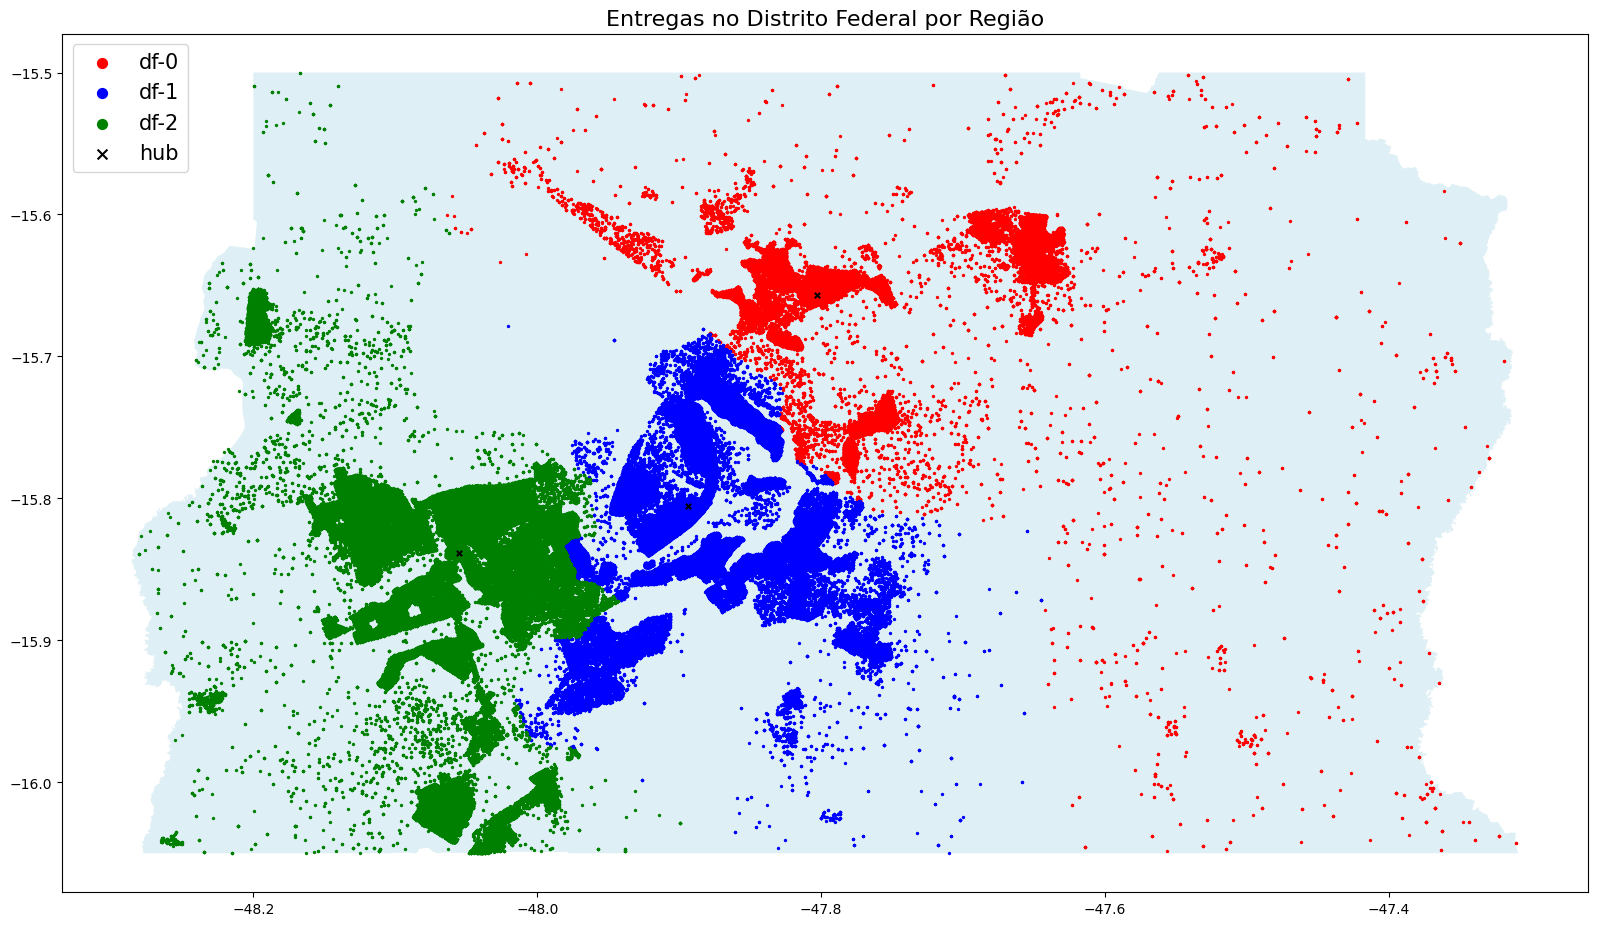

In [ ]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightblue")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=2, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=2, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=2, color="green", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=15, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15},loc="upper left")

for handle in lgnd.legendHandles:
    handle.set_sizes([50])

<ipython-input-36-604891b44bca>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette=c)
<ipython-input-36-604891b44bca>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette=c)


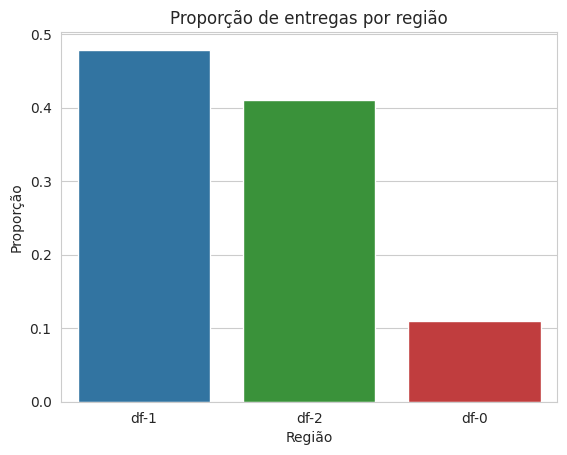

In [ ]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={"proportion": "region_percent"}, inplace=True)
c=["tab:blue","tab:green","tab:red"]
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette=c)
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

In [ ]:
#data frame agrupado com o tamanho das entregas por região
dfx=deliveries_df[["region","delivery_size"]].value_counts()
dfx=pd.DataFrame(dfx)
dfx.rename(columns={"delivery_size": "count"}, inplace=True)


<ipython-input-38-cc95af3825be>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  grafico =  sns.barplot(data=dfx, x="delivery_size", y="count",hue='region', ci=None, palette=c)


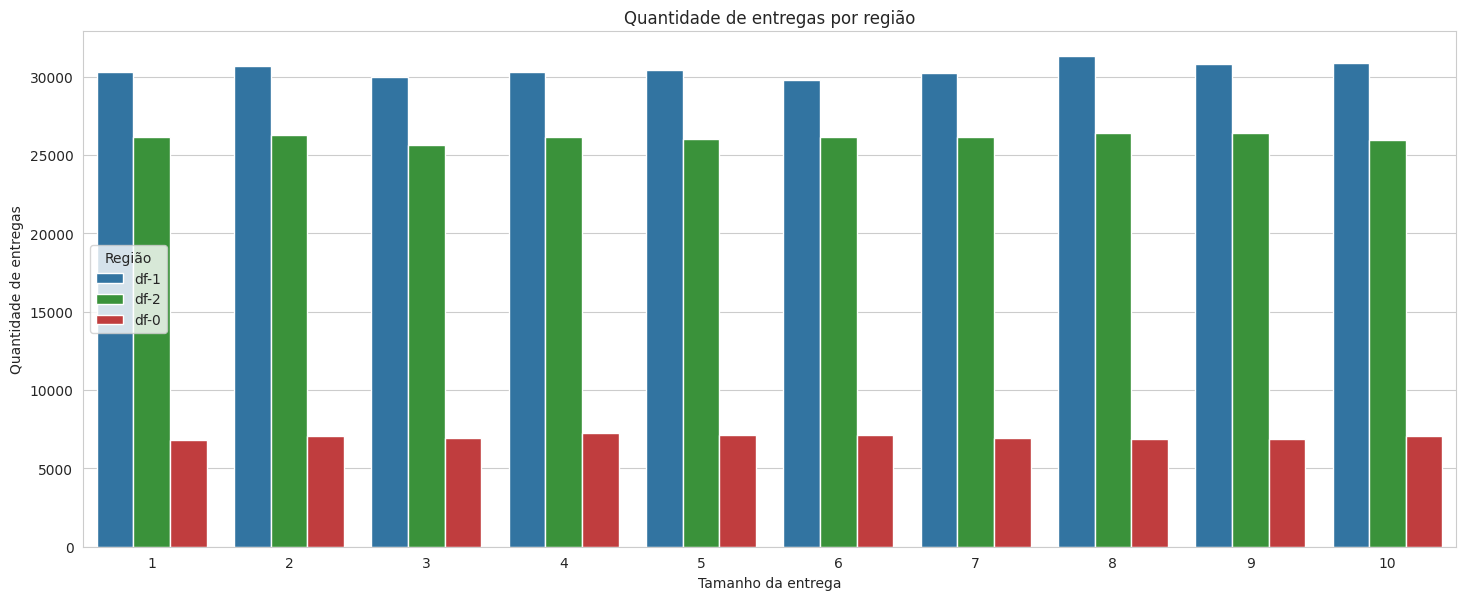

In [ ]:
#definição do grafico
sns.set_style("whitegrid")
grafico =  sns.barplot(data=dfx, x="delivery_size", y="count",hue='region', ci=None, palette=c)

#definição do nome do eixos e titulo do grafico
grafico.set(title='Quantidade de entregas por região',
            xlabel='Tamanho da entrega', ylabel='Quantidade de entregas');

grafico.legend(title='Região', loc='center left') #posição e titulo legenda
grafico.figure.set_size_inches(w=45/2.54, h=17/2.54) #tamanho do grafico

# **Insights**

---
**grafico 1 & 2/mapa:**

 percebe-se que as regiaões df-1 e df-2 possuem uma maioria esmagadora na quantia de entregas tendo seus centros e distribuição nas localidadesd com mais entregas porem o df-0 possuem significativamente menos entregas porem entregas mais logas o que resulta em viagems maiores e mais demoradas.


---


possivel solução:

visando a redução das distancia  de entregas, a criação e um hub menor em regiãoes afastadas dos hubs centrais reduziria o tamanho as viagem e a eficiencias das entregas de modo geral.


---


**grafico 3/barras**

indentificou-se que as entregas possuem uma quantia estavel para cada hub os tamanhos não variam entre hubs na verdade saõ incrivelmente enquilibrados todos entregam todos os tamanho dentro a porpoção e entregas.





